In [1]:
from multiprocessing.connection import Client
import numpy as np
import time
import csv
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

def read_image(image_path):
    """Read an image from the specified path."""
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return gray_image

# Shift the bits of the template
def shiftbits_int(template, noshifts):
    templatenew = np.zeros(template.shape, dtype=np.uint8)
    width = template.shape[1]
    s = 2 * np.abs(noshifts)
    p = width - s

    # If no shift is needed, return the original template
    if noshifts == 0:
        templatenew = template

    # If the shift is positive, shift the bits to the right
    elif noshifts < 0:
        x = np.arange(p)
        templatenew[:, x] = template[:, s + x]
        x = np.arange(p, width)
        templatenew[:, x] = template[:, x - p]

    # If the shift is negative, shift the bits to the left
    else:
        x = np.arange(s, width)
        templatenew[:, x] = template[:, x - s]
        x = np.arange(s)
        templatenew[:, x] = template[:, p + x]

    return templatenew

def send_task(input_template , address=('localhost', 6000), authkey=b'sabig'):
    conn = Client(address, authkey=authkey)
    #print("[Client] Sending array...")
    conn.send(input_template)
    result = conn.recv()
    conn.close()
    return result

In [2]:
temp_df = pd.DataFrame(data=np.zeros([1200, 1200]), columns=[f"Folder {f} Image {i}" for f in range(60) for i in range(20)], index=[f"Folder {f} Image {i}" for f in range(60) for i in range(20)], dtype=object)

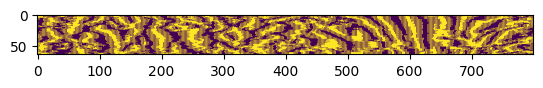

In [3]:
init_path = '/home/surasak'
packed_shifted_template1 = []
count = 0
f2 = 0
i2 = 0
template = read_image(os.path.join(init_path, 'data', \
        f'CASIA-IrisV2/device2/00{str(f2).zfill(2)}_template/00{str(f2).zfill(2)}_0{str(i2).zfill(2)}.bmp'))[:, :, 0]
plt.imshow(template)

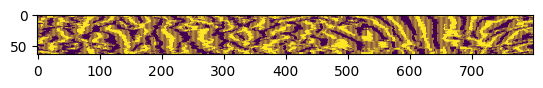

In [4]:
packed_shifted_template = []
for l, shifts in enumerate(range(-8, 9)):
    shifted_template = shiftbits_int(template, shifts)
    packed_shifted_template.append(np.packbits(shifted_template.flatten()))
plt.imshow(shifted_template)

In [5]:
packed_shifted_template1 = np.asarray(packed_shifted_template)
print(f'Example input: {packed_shifted_template1[0,0:10]}')

Example input: [213   2 175 255 213  80   0  84   2 171]


In [7]:
start = time.perf_counter()
# result = send_task(template1, arr)
k = 0
result = send_task(packed_shifted_template1)
for idx, hd_all in result:
    no_templates = hd_all.shape[0]
    for i in range(no_templates):
        temp_df.iloc[k, idx*no_templates+i] =  list(hd_all[i,:])

duration = time.perf_counter() - start
print(f"duration time {duration} sec")

#temp_df.to_csv('/home/surasak/Folk/tempdf5.csv')

duration time 0.11784735300000193 sec


In [47]:
packed_shifted_template1 = []
for f2 in range(60):
    for i2 in range(20):
        template = read_image(os.path.join(init_path, 'data', \
                    f'CASIA-IrisV2/device2/00{str(f2).zfill(2)}_template/00{str(f2).zfill(2)}_0{str(i2).zfill(2)}.bmp'))[:, :, 0]
        packed_shifted_template = []
        for l, shifts in enumerate(range(-8, 9)):
            shifted_template = shiftbits_int(template, shifts)
            packed_shifted_template.append(np.packbits(shifted_template.flatten()))
        packed_shifted_template1.append(packed_shifted_template)        

packed_shifted_template1 = np.asarray(packed_shifted_template1)

In [49]:
packed_shifted_template1[0,:,:].shape

(17, 6400)

In [54]:
start = time.perf_counter()
# result = send_task(template1, arr)
for k in range(1200):
    template1 = packed_shifted_template1[k,:,:]
    result = send_task(template1)
    for idx, hd_all in result:
        no_templates = hd_all.shape[0]
        for i in range(no_templates):
            temp_df.iloc[k, idx*no_templates+i] =  list(hd_all[i,:])
duration = time.perf_counter() - start
print(f"duration time {duration} sec")

duration time 116.5735184669993 sec


In [53]:
temp_df.to_csv('/home/surasak/Folk/tempdf5.csv')